#### Hosting a trained machine learning model in Amazon SageMaker. We are deploying and monitoring a machine learning model trained on bank marketing data, with a focus on detecting quality drift.

The model we are deploying demonstrates how to identify potential customers for targeted marketing campaigns. It has been trained using a publicly available banking and marketing dataset repository. This dataset contains information about customers as well as details of their behavior in response to previous marketing contacts. We use this data to identify which customers are most likely to subscribe to a new product. In the sample dataset, the product is a bank term deposit. A bank term deposit is a deposit made into a bank with a fixed interest rate that cannot be withdrawn for a certain period, also known as a certificate of deposit (CD).

Lets use the trained model, "BankMarketingTarget.tar.gz," along with its training, testing, and validation datasets that would helpful  in creating baseline and to generate synthetic data from the model endpoint, where the inference data is captured and validated against the baseline to detect drift.



This notebook shows how to:
* Host a machine learning model in Amazon SageMaker and capture inference requests, results, and metadata 
* Generate a baseline of model quality and suggested constraints
* Monitor a live endpoint for violations against the suggested constraints
* Generate CloudWatch Alarms on model quality drift


**Table of Contents** 

1. [Introduction](#intro)
2. [Section 1 - Setup](#setup)
3. [Section 2 - Deploy pre-trained model with data capture enabled](#deploy)
5. [Section 3 - Generate baseline for model quality performance](#generate-baseline)
6. [Section 4 - Setup continuous model monitoring to identify model quality drift](#analyze-model-quality-drift)
7. [Section 5 - Analyze model quality CloudWatch metrics](#analyze-cloudwatch-metrics)
8. [Clean up](#cleanup)



## Introduction <a id='intro'></a>    

Amazon SageMaker provides every developer and data scientist with the ability to build, train, and deploy machine learning (ML) models quickly by bringing together a broad set of capabilities purpose-built for ML. Amazon SageMaker is a fully-managed service that encompasses the entire ML workflow. You can label and prepare your data, choose an algorithm, train a model, and then tune and optimize it for deployment. You can deploy your models to production with Amazon SageMaker to make predictions and lower costs than it was previously possible.

Amazon SageMaker Model Monitor allows you to maintain high quality ML models by automatically detecting and helping you remediate inaccuracies in model predictions. Model Monitor helps
you detect changes in properties of independent variables to help maintain data quality, and
monitors model performance characteristics such as accuracy and precision in real-time to
help maintain model quality.

In this notebook, you learn how to use Amazon SageMaker model quality monitoring capability to monitor model performance characteristics of your in-production ML models. You will learn how to configure Amazon CloudWatch alerts to get notified if the model quality degrades from the configured baseline quality.

## Section 1 - Setup <a id='setup'></a>

In this section, you will import the necessary libraries, setup variables and examine data that was used to train the XGBoost Banking Customer Term Deposit Prediction model provided with this notebook.

Let's start by specifying:

* The AWS region used to host your model.
* The IAM role associated with this SageMaker notebook instance.
* The S3 bucket used to store the data used to train your model, any additional model data, and the data captured from model invocations.

#### 1.1 Import necessary libraries

In [ ]:
%%time

from datetime import datetime, timedelta, timezone
import json
import os
import re
import boto3
from time import sleep
from threading import Thread

import pandas as pd

from sagemaker import get_execution_role, session, Session, image_uris
from sagemaker.s3 import S3Downloader, S3Uploader
from sagemaker.processing import ProcessingJob
from sagemaker.serializers import CSVSerializer

from sagemaker.model import Model
from sagemaker.model_monitor import DataCaptureConfig

session = Session()

#### 1.2 AWS region and  IAM Role

In [ ]:
# Get Execution role
role = get_execution_role()
print("RoleArn:", role)

region = session.boto_region_name
print("Region:", region)

#### 1.3 S3 bucket and prefixes

In [ ]:
# Setup S3 bucket
# You can use a different bucket, but make sure the role you chose for this notebook
# has the s3:PutObject permissions. This is the bucket into which the data is captured
bucket = session.default_bucket()
print("Demo Bucket:", bucket)
prefix = "sagemaker/Banking-ModelQualityMonitor-20240827"

##S3 prefixes
data_capture_prefix = f"{prefix}/datacapture"
s3_capture_upload_path = f"s3://{bucket}/{data_capture_prefix}"

ground_truth_upload_path = (
    f"s3://{bucket}/{prefix}/ground_truth_data/{datetime.now():%Y-%m-%d-%H-%M-%S}"
)

reports_prefix = f"{prefix}/reports"
s3_report_path = f"s3://{bucket}/{reports_prefix}"

##Get the model monitor image
monitor_image_uri = image_uris.retrieve(framework="model-monitor", region=region)

print("Image URI:", monitor_image_uri)
print(f"Capture path: {s3_capture_upload_path}")
print(f"Ground truth path: {ground_truth_upload_path}")
print(f"Report path: {s3_report_path}")

## Section 2 - Deploy pre-trained model with data capture enabled <a id='deploy'></a>

In this section, We will use our existing  pretrained model from the S3 bucket, create an Amazon SageMaker Model, create an Amazon SageMaker real time endpoint, and enable data capture on the endpoint to capture endpoint invocations, predictions, and metadata.

#### 2.1 Upload the pretrained model to S3

In [ ]:
##Upload the pretrained model to S3
s3_key = f"s3://{bucket}/{prefix}"
model_url = S3Uploader.upload("model/BankMarketingTarget.tar.gz", s3_key)
model_url

#### 2.2 Create SageMaker Model entity

This step creates an Amazon SageMaker model from the  model file uploaded to S3.

In [ ]:
model_name = f"BankMarketingTarget-pred-model-{datetime.utcnow():%Y-%m-%d-%H%M}"

image_uri = image_uris.retrieve(framework="xgboost", version="0.90-1", region=region)

model = Model(image_uri=image_uri, model_data=model_url, role=role, sagemaker_session=session)

#### 2.3 Deploy the model with data capture enabled.
Next, deploy the SageMaker model on a specific instance with data capture enabled.

In [ ]:
endpoint_name = f"BankMarketingTarget-endpoint-{datetime.utcnow():%Y-%m-%d-%H%M}"
print("EndpointName =", endpoint_name)

data_capture_config = DataCaptureConfig(
    enable_capture=True, sampling_percentage=100, destination_s3_uri=s3_capture_upload_path
)

model.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    endpoint_name=endpoint_name,
    data_capture_config=data_capture_config,
)

#### 2.4 Create the SageMaker Predictor object from the endpoint to be used for invoking the model

In [ ]:
from sagemaker.predictor import Predictor

predictor = Predictor(
    endpoint_name=endpoint_name, sagemaker_session=session, serializer=CSVSerializer()
)

##  Section 3 - Generate a baseline for model quality performance <a id='generate-baseline'></a>

In this section, you will invoke the endpoint created above using validation data. Predictions from the deployed model using this validation data will be used as a baseline dataset.  You will then use SageMaker's Model Monitoring to execute a baseline job that computes model performance data, and suggest model quality constraints based on the baseline dataset.

#### 3.1 Execute predictions using the validation dataset. 

The deployed model returns probability that a customer will do a Term Deposit. Let's choose an arbitrary 0.8 cutoff to consider that a customer will enrol for Term Deposit.

In [ ]:
churn_cutoff = 0.8
validate_dataset = "data/validation_with_predictions.csv"

In [ ]:
limit = 200  # Need at least 200 samples to compute standard deviations
i = 0
with open(f"{validate_dataset}", "w") as baseline_file:
    baseline_file.write("probability,prediction,label\n")  # our header
    with open("data/validation.csv", "r") as f:
        for row in f:
            (label, input_cols) = row.split(",", 1)
            probability = float(predictor.predict(input_cols))
            prediction = "1" if probability > churn_cutoff else "0"
            baseline_file.write(f"{probability},{prediction},{label}\n")
            i += 1
            if i > limit:
                break
            print(".", end="", flush=True)
            sleep(0.5)
print()
print("Done!")

#### 3.2 Examine the predictions from the model

In [ ]:
!head data/validation_with_predictions.csv

#### 3.3 Upload the predictions as a baseline dataset.
Now we will upload the predictions made using validation dataset to S3 which will be used for creating model quality baseline statistics and constraints

In [ ]:
baseline_prefix = prefix + "/baselining"
baseline_data_prefix = baseline_prefix + "/data"
baseline_results_prefix = baseline_prefix + "/results"

baseline_data_uri = f"s3://{bucket}/{baseline_data_prefix}"
baseline_results_uri = f"s3://{bucket}/{baseline_results_prefix}"
print(f"Baseline data uri: {baseline_data_uri}")
print(f"Baseline results uri: {baseline_results_uri}")

In [ ]:
baseline_dataset_uri = S3Uploader.upload(f"{validate_dataset}", baseline_data_uri)
baseline_dataset_uri

#### 3.4 Create a baselining job with validation dataset predictions
Define the model quality monitoring object and execute the model quality monitoring baseline job. Model monitor will automatically generate baseline statistics and constraints based on the validation dataset provided.

In [ ]:
from sagemaker.model_monitor import ModelQualityMonitor
from sagemaker.model_monitor import EndpointInput
from sagemaker.model_monitor.dataset_format import DatasetFormat

In [ ]:
# Create the model quality monitoring object
Banking_Quality_Monitor = ModelQualityMonitor(
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    volume_size_in_gb=20,
    max_runtime_in_seconds=1800,
    sagemaker_session=session,
)

In [ ]:
# Name of the model quality baseline job
baseline_job_name = f"BankMarketingTarget-baseline-job-{datetime.utcnow():%Y-%m-%d-%H%M}"

In [ ]:
# Execute the baseline suggestion job.
# You will specify problem type, in this case Binary Classification, and provide other required attributes.
job = Banking_Quality_Monitor.suggest_baseline(
    job_name=baseline_job_name,
    baseline_dataset=baseline_dataset_uri,
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri=baseline_results_uri,
    problem_type="BinaryClassification",
    inference_attribute="prediction",
    probability_attribute="probability",
    ground_truth_attribute="label",
)
job.wait(logs=False)

#### 3.5 Explore the results of the baselining job
You could see the baseline constraints and statistics files are uploaded to the S3 location.

In [ ]:
baseline_job = Banking_Quality_Monitor.latest_baselining_job

In [ ]:
binary_metrics = baseline_job.baseline_statistics().body_dict["binary_classification_metrics"]
pd.json_normalize(binary_metrics).T

##### 3.5.2 View the constraints generated

In [ ]:
pd.DataFrame(baseline_job.suggested_constraints().body_dict["binary_classification_constraints"]).T

In the above example you can see that model quality monitor suggested a constraint that need to be ensured that the model accuracy and  AUC score should note drop below 0.91 and 0.92 respectively.

##  Section 4 - Setup continuous model monitoring to identify model quality drift <a id='analyze-model-quality-drift'></a>

In this section, you will setup a continuous model monitoring job that monitors the quality of the deployed model against the baseline generated in the previous section.  This is to ensure that the quality does not degrade over time.

In addition to the generated baseline, Amazon SageMaker Model Quality Monitoring needs two additional inputs - predictions made by the deployed model endpoint and the ground truth data to be provided by the model consuming application.  Since you already enabled data capture on the endpoint, prediction data is captured in S3.  The ground truth data depends on the what your model is predicting and what the business use case is.  In this case, since the model is predicting wheather customer will enroll for a term deposit or not.  For the purposes of this notebook, you will generate synthetic data as ground truth.

#### 4.1 Generate prediction data for Model Quality  Monitoring
Start generating some artificial traffic. The cell below starts a thread to send some traffic to the endpoint. Note that you need to stop the kernel to terminate this thread. If there is no traffic, the monitoring jobs are marked as Failed since there is no data to process.We are using the test data set by dropping the predicter label  to send data to endpoint to enable synthtehic data generation you can also use train dataset.

In [ ]:
def invoke_endpoint(ep_name, file_name):
    with open(file_name, "r") as f:
        i = 0
        for row in f:
            payload = row.rstrip("\n")
            response = session.sagemaker_runtime_client.invoke_endpoint(
                EndpointName=endpoint_name,
                ContentType="text/csv",
                Body=payload,
                InferenceId=str(i),  # unique ID per row
            )["Body"].read()
            i += 1
            sleep(1)


def invoke_endpoint_forever():
    while True:
        try:
            invoke_endpoint(endpoint_name, "data/test.csv")
        except session.sagemaker_runtime_client.exceptions.ValidationError:
            pass


thread = Thread(target=invoke_endpoint_forever)
thread.start()

#### 4.2 View captured data

Now list the data capture files stored in Amazon S3. You should expect to see different files from different time periods organized based on the hour in which the invocation occurred. The format of the Amazon S3 path is:

`s3://{destination-bucket-prefix}/{endpoint-name}/{variant-name}/yyyy/mm/dd/hh/filename.jsonl`

In [ ]:
print("Waiting for captures to show up", end="")
for _ in range(120):
    capture_files = sorted(S3Downloader.list(f"{s3_capture_upload_path}/{endpoint_name}"))
    if capture_files:
        capture_file = S3Downloader.read_file(capture_files[-1]).split("\n")
        capture_record = json.loads(capture_file[0])
        if "inferenceId" in capture_record["eventMetadata"]:
            break
    print(".", end="", flush=True)
    sleep(1)
print()
print("Found Capture Files:")
print("\n ".join(capture_files[-3:]))

In [ ]:
print("\n".join(capture_file[-3:-1]))

In [ ]:
print(json.dumps(capture_record, indent=2))

#### 4.3 Generate synthetic ground truth

Next, start generating ground truth data. The model quality job will fail if there's no ground truth data to merge.

In [ ]:
import random


def ground_truth_with_id(inference_id):
    random.seed(inference_id)  # to get consistent results
    rand = random.random()
    return {
        "groundTruthData": {
            "data": "1" if rand < 0.7 else "0",  # randomly generate positive labels 70% of the time
            "encoding": "CSV",
        },
        "eventMetadata": {
            "eventId": str(inference_id),
        },
        "eventVersion": "0",
    }


def upload_ground_truth(records, upload_time):
    fake_records = [json.dumps(r) for r in records]
    data_to_upload = "\n".join(fake_records)
    target_s3_uri = f"{ground_truth_upload_path}/{upload_time:%Y/%m/%d/%H/%M%S}.jsonl"
    print(f"Uploading {len(fake_records)} records to", target_s3_uri)
    S3Uploader.upload_string_as_file_body(data_to_upload, target_s3_uri)

In [ ]:
NUM_GROUND_TRUTH_RECORDS = 500  # 500 are the number of rows in data we're sending for inference


def generate_fake_ground_truth_forever():
    j = 0
    while True:
        fake_records = [ground_truth_with_id(i) for i in range(NUM_GROUND_TRUTH_RECORDS)]
        upload_ground_truth(fake_records, datetime.utcnow())
        j = (j + 1) % 5
        sleep(60 * 60)  # do this once an hour


gt_thread = Thread(target=generate_fake_ground_truth_forever)
gt_thread.start()

#### 4.4 Create a monitoring schedule

Now that you have the baseline information and ground truth labels, create a monitoring schedule to run model quality monitoring job.

In [ ]:
##Monitoring schedule name
Banking_monitor_schedule_name = (
    f"BankMarketingTarget-monitoring-schedule-{datetime.utcnow():%Y-%m-%d-%H%M}"
)

For the monitoring schedule you need to specify how to interpret an endpoint's output. Given that the endpoint in this notebook outputs CSV data, the below code specifies that the first column of the output, `0`, contains a probability (of churn in this example). You will further specify `0.5` as the cutoff  used to determine a positive label (that is, predict that a customer will churn).

In [ ]:
# Create an enpointInput
endpointInput = EndpointInput(
    endpoint_name=predictor.endpoint_name,
    probability_attribute="0",
    probability_threshold_attribute=0.5,
    destination="/opt/ml/processing/input_data",
)

In [ ]:
# Create the monitoring schedule to execute every hour.
from sagemaker.model_monitor import CronExpressionGenerator

response = Banking_Quality_Monitor.create_monitoring_schedule(
    monitor_schedule_name=Banking_monitor_schedule_name,
    endpoint_input=endpointInput,
    output_s3_uri=baseline_results_uri,
    problem_type="BinaryClassification",
    ground_truth_input=ground_truth_upload_path,
    constraints=baseline_job.suggested_constraints(),
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True,
)

In [ ]:
# Create the monitoring schedule
# You will see the monitoring schedule in the 'Scheduled' status
Banking_Quality_Monitor.describe_schedule()

#### 4.5 Examine monitoring schedule executions

In [ ]:
# Initially there will be no executions since the first execution happens at the top of the hour
# Note that it is common for the execution to luanch upto 20 min after the hour.
executions = Banking_Quality_Monitor.list_executions()
executions

In [ ]:
# Wait for the first execution of the monitoring_schedule
print("Waiting for first execution", end="")
while True:
    execution = Banking_Quality_Monitor.describe_schedule().get(
        "LastMonitoringExecutionSummary"
    )
    if execution:
        break
    print(".", end="", flush=True)
    sleep(10)
print()
print("Execution found!")

In [ ]:
while not executions:
    executions = Banking_Quality_Monitor.list_executions()
    sleep(10)
latest_execution = executions[-1]
latest_execution.describe()

##### Inspect a specific execution (latest execution)
In the previous cell, you picked up the latest completed or failed scheduled execution. Here are the possible terminal states and what each of them mean: 
* Completed - This means the monitoring execution completed and no issues were found in the violations report.
* CompletedWithViolations - This means the execution completed, but constraint violations were detected.
* Failed - The monitoring execution failed, maybe due to client error (perhaps incorrect role permissions) or infrastructure issues. Further examination of FailureReason and ExitMessage is necessary to identify what exactly happened.
* Stopped - job exceeded max runtime or was manually stopped.

In [ ]:
status = execution["MonitoringExecutionStatus"]

while status in ["Pending", "InProgress"]:
    print("Waiting for execution to finish", end="")
    latest_execution.wait(logs=False)
    latest_job = latest_execution.describe()
    print()
    print(f"{latest_job['ProcessingJobName']} job status:", latest_job["ProcessingJobStatus"])
    print(
        f"{latest_job['ProcessingJobName']} job exit message, if any:",
        latest_job.get("ExitMessage"),
    )
    print(
        f"{latest_job['ProcessingJobName']} job failure reason, if any:",
        latest_job.get("FailureReason"),
    )
    sleep(
        30
    )  # model quality executions consist of two Processing jobs, wait for second job to start
    latest_execution = Banking_Quality_Monitor.list_executions()[-1]
    execution = Banking_Quality_Monitor.describe_schedule()["LastMonitoringExecutionSummary"]
    status = execution["MonitoringExecutionStatus"]

print("Execution status is:", status)

if status != "Completed":
    print(execution)
    print(
        "====STOP==== \n No completed executions to inspect further. Please wait till an execution completes or investigate previously reported failures."
    )

In [ ]:
latest_execution = Banking_Quality_Monitor.list_executions()[-1]
report_uri = latest_execution.describe()["ProcessingOutputConfig"]["Outputs"][0]["S3Output"][
    "S3Uri"
]
print("Report Uri:", report_uri)

#### 4.6 View violations generated by monitoring schedule

If there are any violations compared to the baseline, they will be listed in the reports uploaded to S3.

In [ ]:
pd.options.display.max_colwidth = None
violations = latest_execution.constraint_violations().body_dict["violations"]
violations_df = pd.json_normalize(violations)
violations_df.head(10)

## Section 5 - Analyze model quality CloudWatch metrics <a id='analyze-cloudwatch-metrics'></a> 

In addition to the violations, the monitoring schedule also emits CloudWatch metrics. In this section, you will view the metrics generated and setup an CloudWatch alarm to be triggered when the model quality drifts from the baseline thresholds. You could use CloudWatch alarms to trigger remedial actions such as retraining your model or updating the training dataset.

#### 5.1 List the CW metrics generated.

In [ ]:
# Create CloudWatch client
cw_client = boto3.Session().client("cloudwatch")

namespace = "aws/sagemaker/Endpoints/model-metrics"

cw_dimensions = [
    {"Name": "Endpoint", "Value": endpoint_name},
    {"Name": "MonitoringSchedule", "Value": Banking_monitor_schedule_name},
]

In [ ]:
# List metrics through the pagination interface
paginator = cw_client.get_paginator("list_metrics")

for response in paginator.paginate(Dimensions=cw_dimensions, Namespace=namespace):
    model_quality_metrics = response["Metrics"]
    for metric in model_quality_metrics:
        print(metric["MetricName"])

#### 5.2 Create a CloudWatch Alarm

Based on the cloud watch metrics, you can create a cloud watch alarm when a specific metric does not meet the threshold configured. Here you will create an alarm if the Accuracy value of the model fall below the threshold suggested by the baseline constraints.

In [ ]:
alarm_name = "BANKING_MODEL_QUALITY_ACCURACY_SCORE"
alarm_desc = (
    "Trigger an CloudWatch alarm when the ACCURACY score drifts away from the baseline constraints"
)
model_quality_accuracy_drift_threshold = (
    0.91  ##Setting this threshold purposefully low to see the alarm quickly.
)
metric_name = "accuracy"
namespace = "aws/sagemaker/Endpoints/model-metrics"

cw_client.put_metric_alarm(
    AlarmName=alarm_name,
    AlarmDescription=alarm_desc,
    ActionsEnabled=True,
    MetricName=metric_name,
    Namespace=namespace,
    Statistic="Average",
    Dimensions=[
        {"Name": "Endpoint", "Value": endpoint_name},
        {"Name": "MonitoringSchedule", "Value": Banking_monitor_schedule_name},
    ],
    Period=600,
    EvaluationPeriods=1,
    DatapointsToAlarm=1,
    Threshold=model_quality_accuracy_drift_threshold,
    ComparisonOperator="LessThanOrEqualToThreshold",
    TreatMissingData="breaching",
)

#### 5.3 Validation
In a few minutes, we should see a CloudWatch alarm created. The alarm will first be in "Insufficient Data" state and moves into "Alert" state. This can be verified in the CloudWatch console

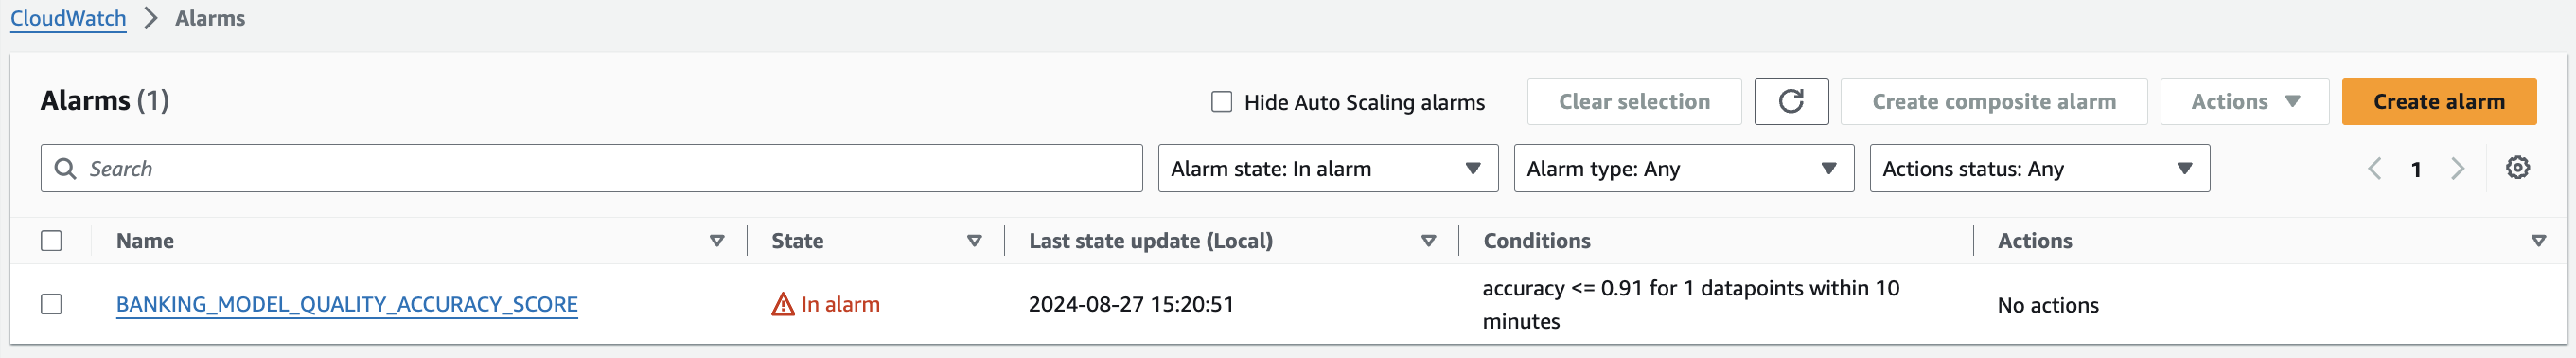

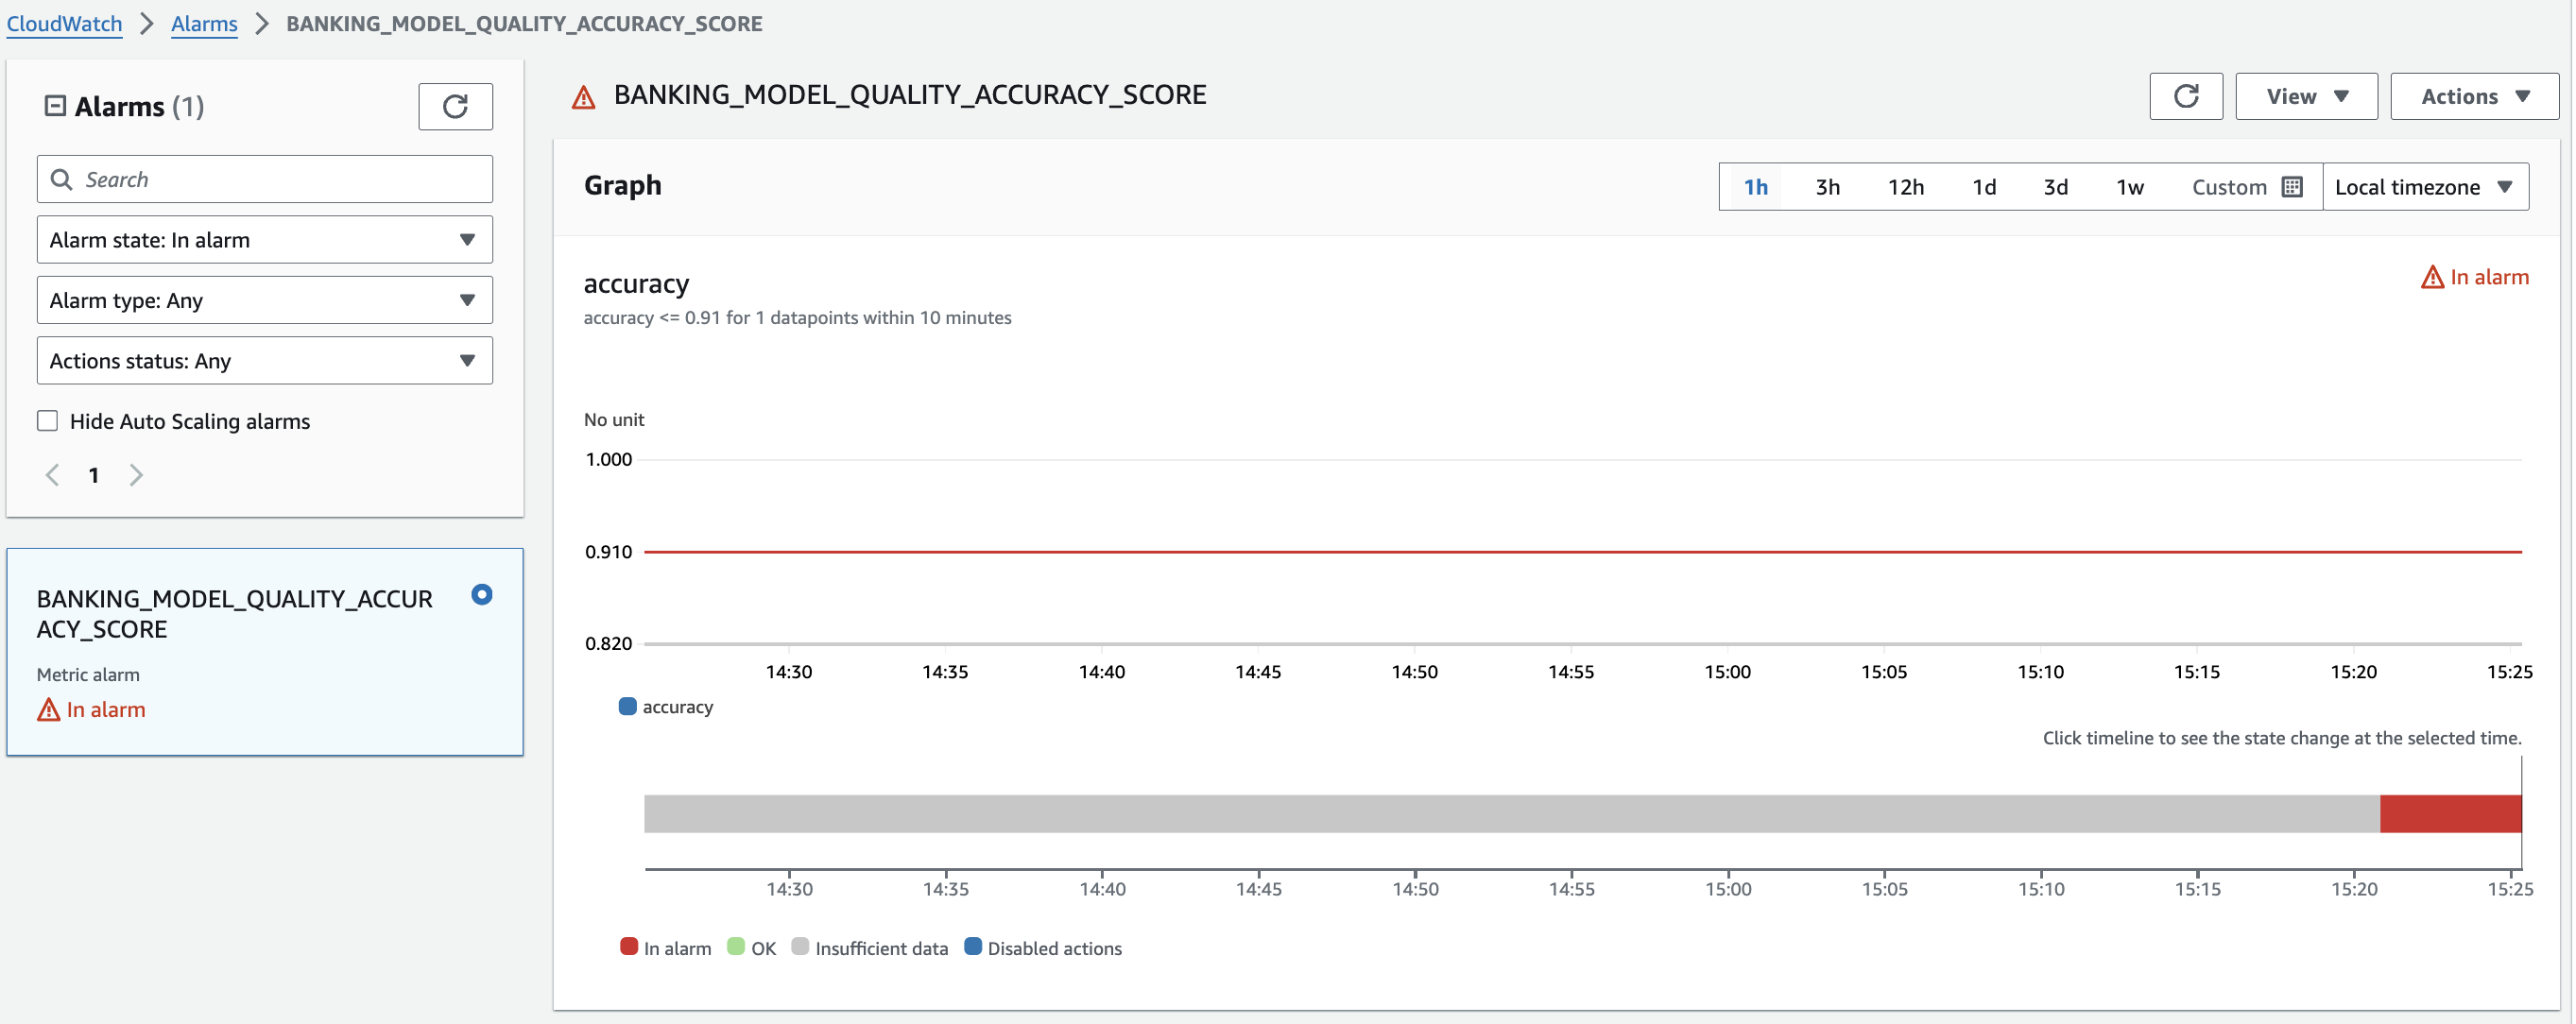

##### Clean up
You can keep your endpoint running to continue capturing data. If you do not plan to collect more data or use this endpoint further, you should delete the endpoint to avoid incurring additional charges. Note that deleting your endpoint does not delete the data that was captured during the model invocations. That data persists in Amazon S3 until you delete it yourself.

But before that, you need to delete the schedule first.

In [ ]:
churn_model_quality_monitor.delete_monitoring_schedule()
sleep(60)  # actually wait for the deletion

In [ ]:
predictor.delete_model()
predictor.delete_endpoint()